<a id="1"></a> <br>
## Step 1 : Data Understanding

In [9]:
# Importar as libs necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [10]:
retail = pd.read_csv('ecommerce.csv', sep=",",encoding="ISO-8859-1", header=0)
retail = retail[['InvoiceNo','Description','InvoiceDate','Quantity','UnitPrice','CustomerID']]
retail = retail.rename(columns = {'InvoiceNo': "id_pedido",
                                    'Description': "descricao",
                                    'InvoiceDate': "data_pgto",
                                    'Quantity' : "quantidade",
                                    'UnitPrice' : "preco_unitario",
                                    'CustomerID': "id_cliente"})
retail.head()

id_pedido                            descricao       data_pgto  quantidade  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER  12/1/2010 8:26           6   
1    536365                  WHITE METAL LANTERN  12/1/2010 8:26           6   
2    536365       CREAM CUPID HEARTS COAT HANGER  12/1/2010 8:26           8   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE  12/1/2010 8:26           6   
4    536365       RED WOOLLY HOTTIE WHITE HEART.  12/1/2010 8:26           6   

   preco_unitario  id_cliente  
0            2.55     17850.0  
1            3.39     17850.0  
2            2.75     17850.0  
3            3.39     17850.0  
4            3.39     17850.0

In [11]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_pedido       541909 non-null  object 
 1   descricao       540455 non-null  object 
 2   data_pgto       541909 non-null  object 
 3   quantidade      541909 non-null  int64  
 4   preco_unitario  541909 non-null  float64
 5   id_cliente      406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


In [12]:
# df descrição

retail.describe()

quantidade  preco_unitario     id_cliente
count  541909.000000   541909.000000  406829.000000
mean        9.552250        4.611114   15287.690570
std       218.081158       96.759853    1713.600303
min    -80995.000000   -11062.060000   12346.000000
25%         1.000000        1.250000   13953.000000
50%         3.000000        2.080000   15152.000000
75%        10.000000        4.130000   16791.000000
max     80995.000000    38970.000000   18287.000000

<a id="2"></a> <br>
## Step 2 : Data Cleaning

In [13]:
# Calcular % de nulos

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

id_pedido          0.00
descricao          0.27
data_pgto          0.00
quantidade         0.00
preco_unitario     0.00
id_cliente        24.93
dtype: float64

In [14]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 6)

In [15]:
retail.describe()

quantidade  preco_unitario     id_cliente
count  406829.000000   406829.000000  406829.000000
mean       12.061303        3.460471   15287.690570
std       248.693370       69.315162    1713.600303
min    -80995.000000        0.000000   12346.000000
25%         2.000000        1.250000   13953.000000
50%         5.000000        1.950000   15152.000000
75%        12.000000        3.750000   16791.000000
max     80995.000000    38970.000000   18287.000000

In [16]:
# Transformar id_cliente em string

retail['id_cliente'] = retail['id_cliente'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [17]:
retail.head()

id_pedido                            descricao       data_pgto  quantidade  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER  12/1/2010 8:26           6   
1    536365                  WHITE METAL LANTERN  12/1/2010 8:26           6   
2    536365       CREAM CUPID HEARTS COAT HANGER  12/1/2010 8:26           8   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE  12/1/2010 8:26           6   
4    536365       RED WOOLLY HOTTIE WHITE HEART.  12/1/2010 8:26           6   

   preco_unitario id_cliente  
0            2.55    17850.0  
1            3.39    17850.0  
2            2.75    17850.0  
3            3.39    17850.0  
4            3.39    17850.0

In [18]:
# Novo atributo : Ticket Médio
rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum})
rfm_m.dtypes

/tmp/ipykernel_287027/789010543.py:2: FutureWarning: The provided callable <function sum at 0x790634790b80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum})


preco_unitario    float64
dtype: object

In [19]:
rfm_m.head()

preco_unitario
id_cliente                
12346.0               2.08
12347.0             481.21
12348.0             178.71
12349.0             605.10
12350.0              65.30

In [20]:
rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum,"id_pedido": lambda x : x.nunique()})
rfm_m['id_pedido'] = rfm_m['id_pedido'].astype(float)
rfm_m.head()

/tmp/ipykernel_287027/2544999588.py:1: FutureWarning: The provided callable <function sum at 0x790634790b80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum,"id_pedido": lambda x : x.nunique()})


preco_unitario  id_pedido
id_cliente                           
12346.0               2.08        2.0
12347.0             481.21        7.0
12348.0             178.71        4.0
12349.0             605.10        1.0
12350.0              65.30        1.0

In [21]:
# Novo atributo : Ticket Médio
rfm_m['ticket_medio'] = rfm_m['preco_unitario']/rfm_m['id_pedido']
rfm_m.head()

preco_unitario  id_pedido  ticket_medio
id_cliente                                         
12346.0               2.08        2.0      1.040000
12347.0             481.21        7.0     68.744286
12348.0             178.71        4.0     44.677500
12349.0             605.10        1.0    605.100000
12350.0              65.30        1.0     65.300000

In [22]:
# Novo atributo : Frequência

rfm_f = retail.groupby('id_cliente')['id_pedido'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['id_cliente', 'frequencia']
rfm_f.head()

id_cliente  frequencia
0    12346.0           2
1    12347.0         182
2    12348.0          31
3    12349.0          73
4    12350.0          17

In [23]:
# Unindo os 2 datasets

rfm = pd.merge(rfm_m, rfm_f, on='id_cliente', how='inner')
rfm.head()

id_cliente  preco_unitario  id_pedido  ticket_medio  frequencia
0    12346.0            2.08        2.0      1.040000           2
1    12347.0          481.21        7.0     68.744286         182
2    12348.0          178.71        4.0     44.677500          31
3    12349.0          605.10        1.0    605.100000          73
4    12350.0           65.30        1.0     65.300000          17

In [24]:
# Novo atributo : Recência

# Convert to datetime to proper datatype

retail['data_pgto'] = pd.to_datetime(retail['data_pgto'])

In [25]:
# Compute the maximum date to know the last transaction date

today = pd.Timestamp.today()
today

Timestamp('2024-09-24 00:48:33.715960')

In [26]:
retail = retail[retail.data_pgto<=today]

In [27]:
retail.head()

id_pedido                            descricao           data_pgto  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER 2010-12-01 08:26:00   
1    536365                  WHITE METAL LANTERN 2010-12-01 08:26:00   
2    536365       CREAM CUPID HEARTS COAT HANGER 2010-12-01 08:26:00   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE 2010-12-01 08:26:00   
4    536365       RED WOOLLY HOTTIE WHITE HEART. 2010-12-01 08:26:00   

   quantidade  preco_unitario id_cliente  
0           6            2.55    17850.0  
1           6            3.39    17850.0  
2           8            2.75    17850.0  
3           6            3.39    17850.0  
4           6            3.39    17850.0

In [28]:
# Compute the difference between max date and transaction date

retail['Diff'] = today - retail['data_pgto']
retail.head()

id_pedido                            descricao           data_pgto  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER 2010-12-01 08:26:00   
1    536365                  WHITE METAL LANTERN 2010-12-01 08:26:00   
2    536365       CREAM CUPID HEARTS COAT HANGER 2010-12-01 08:26:00   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE 2010-12-01 08:26:00   
4    536365       RED WOOLLY HOTTIE WHITE HEART. 2010-12-01 08:26:00   

   quantidade  preco_unitario id_cliente                      Diff  
0           6            2.55    17850.0 5045 days 16:22:33.715960  
1           6            3.39    17850.0 5045 days 16:22:33.715960  
2           8            2.75    17850.0 5045 days 16:22:33.715960  
3           6            3.39    17850.0 5045 days 16:22:33.715960  
4           6            3.39    17850.0 5045 days 16:22:33.715960

In [29]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('id_cliente')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

id_cliente                      Diff
0    12346.0 4997 days 14:31:33.715960
1    12347.0 4674 days 08:56:33.715960
2    12348.0 4747 days 11:35:33.715960
3    12349.0 4690 days 14:57:33.715960
4    12350.0 4982 days 08:47:33.715960

In [30]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

id_cliente  Diff
0    12346.0  4997
1    12347.0  4674
2    12348.0  4747
3    12349.0  4690
4    12350.0  4982

In [31]:
rfm = rfm[['id_cliente','ticket_medio','frequencia']]

In [32]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='id_cliente', how='inner')
rfm.columns = ['id_cliente', 'ticket_medio', 'frequencia', 'recencia']
rfm.head()

id_cliente  ticket_medio  frequencia  recencia
0    12346.0      1.040000           2      4997
1    12347.0     68.744286         182      4674
2    12348.0     44.677500          31      4747
3    12349.0    605.100000          73      4690
4    12350.0     65.300000          17      4982

#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

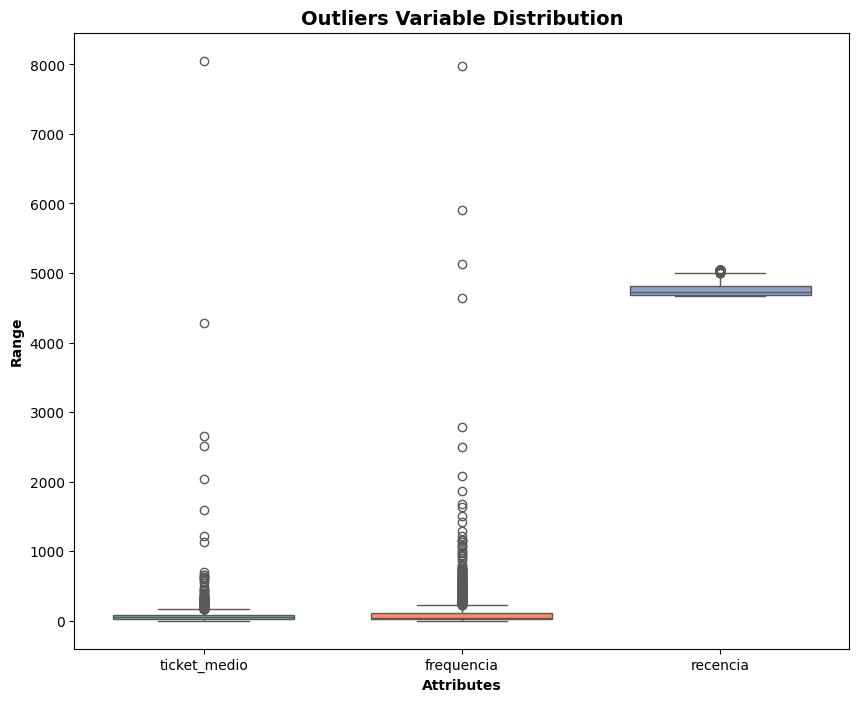

In [33]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['ticket_medio','frequencia','recencia']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [34]:
#Retirando 5% de outlier
rfm=rfm[rfm['ticket_medio'] < rfm['ticket_medio'].quantile(.95)]
rfm=rfm[rfm['frequencia'] < rfm['frequencia'].quantile(.95)]
rfm=rfm[rfm['recencia'] < rfm['recencia'].quantile(.95)]

Text(0.5, 0, 'Attributes')

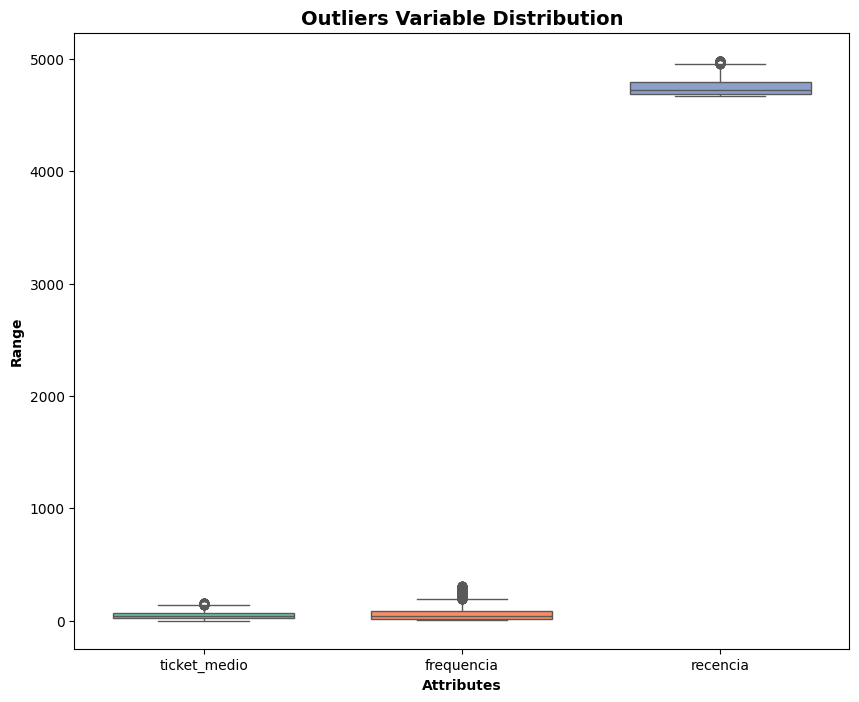

In [35]:
attributes = ['ticket_medio','frequencia','recencia']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [36]:
rfm[['id_cliente','ticket_medio','frequencia','recencia']]

id_cliente  ticket_medio  frequencia  recencia
1       12347.0     68.744286         182      4674
2       12348.0     44.677500          31      4747
4       12350.0     65.300000          17      4982
6       12353.0     24.300000           4      4876
8       12355.0     54.650000          13      4886
...         ...           ...         ...       ...
4366    18278.0     29.550000           9      4745
4367    18280.0     47.650000          10      4949
4368    18281.0     39.360000           7      4852
4369    18282.0     20.893333          13      4679
4371    18287.0     34.850000          70      4714

[3747 rows x 4 columns]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling
2. Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [37]:
from sklearn.preprocessing import MinMaxScaler

rfm_df = rfm[['ticket_medio', 'frequencia','recencia']]

scaler = MinMaxScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
# dimensiona e traduz cada característica individualmente de tal forma que
#  esteja no intervalo dado no conjunto de treinamento, por exemplo, entre zero e um.

In [38]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns = [rfm_df.columns])
rfm_df_scaled.describe()

ticket_medio   frequencia     recencia
count  3747.000000  3747.000000  3747.000000
mean      0.316144     0.199758     0.261286
std       0.221148     0.207978     0.271462
min       0.000000     0.000000     0.000000
25%       0.149432     0.052117     0.054313
50%       0.261613     0.120521     0.156550
75%       0.444983     0.280130     0.396166
max       1.000000     1.000000     1.000000

In [39]:
# Rescaling the attributes

rfm_df = rfm[['ticket_medio', 'frequencia','recencia']]

# Instantiate
scaler = StandardScaler()
# Padronize recursos removendo a média e dimensionando para a variação da unidade.
# media = 0 , desvio padrao = 1

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3747, 3)

In [40]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns = [rfm_df.columns])
rfm_df_scaled.describe()

ticket_medio    frequencia      recencia
count  3.747000e+03  3.747000e+03  3.747000e+03
mean   7.585191e-17  4.361485e-17 -1.952238e-15
std    1.000133e+00  1.000133e+00  1.000133e+00
min   -1.429751e+00 -9.606041e-01 -9.626439e-01
25%   -7.539490e-01 -7.099801e-01 -7.625406e-01
50%   -2.466147e-01 -3.810361e-01 -3.858756e-01
75%    5.826689e-01  3.864999e-01  4.969331e-01
max    3.092715e+00  3.848244e+00  2.721611e+00

In [41]:
sns.histplot(data=rfm_df_scaled['frequencia'])

<Axes: ylabel='Count'>

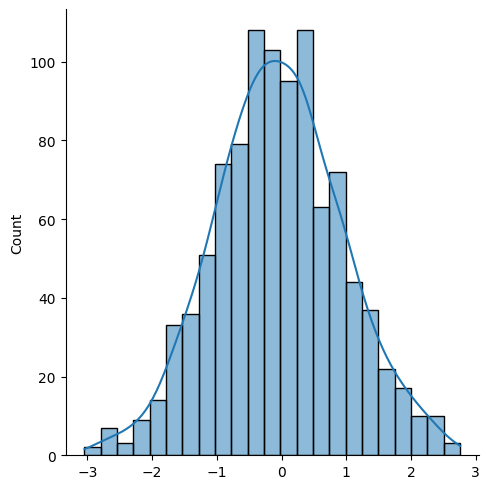

In [42]:
import numpy as np
import seaborn as sns

#make this example reproducible
np.random.seed(0)

#create data
x = np.random.normal(size=1000)

#create normal distribution histogram
sns.displot(x, kde=True)

<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

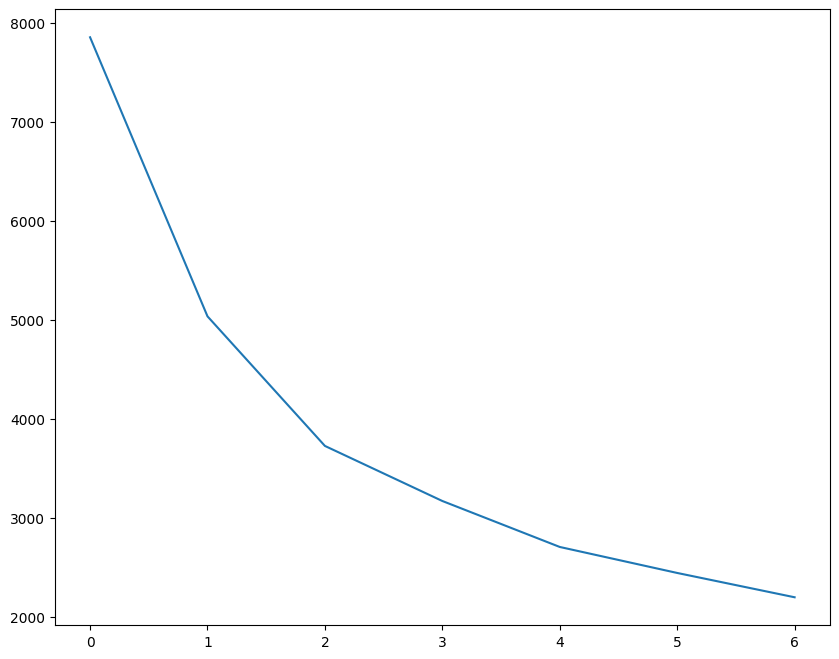

In [43]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1.

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [44]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3405285910331591
For n_clusters=3, the silhouette score is 0.38011546968978466
For n_clusters=4, the silhouette score is 0.4038401352471199
For n_clusters=5, the silhouette score is 0.3425625868113682
For n_clusters=6, the silhouette score is 0.36464866011027797
For n_clusters=7, the silhouette score is 0.3297248303826464
For n_clusters=8, the silhouette score is 0.32955907994058825


In [45]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=10)
kmeans.labels_= kmeans.fit_predict(rfm_df_scaled)
df_kmeans=rfm

In [46]:
kmeans.labels_

array([3, 0, 1, ..., 1, 0, 0], dtype=int32)

In [47]:
# assign the label
df_kmeans['Cluster_Id'] = kmeans.labels_.astype('str')
df_kmeans.head()

id_cliente  ticket_medio  frequencia  recencia Cluster_Id
1    12347.0     68.744286         182      4674          3
2    12348.0     44.677500          31      4747          0
4    12350.0     65.300000          17      4982          1
6    12353.0     24.300000           4      4876          1
8    12355.0     54.650000          13      4886          1

p1        p2 labels
0  2.045237 -0.296268    NaN
1 -0.385817 -0.174261      3
2 -1.652218  2.186026      0
3 -1.743842  0.484515    NaN
4 -1.272858  1.177179      1

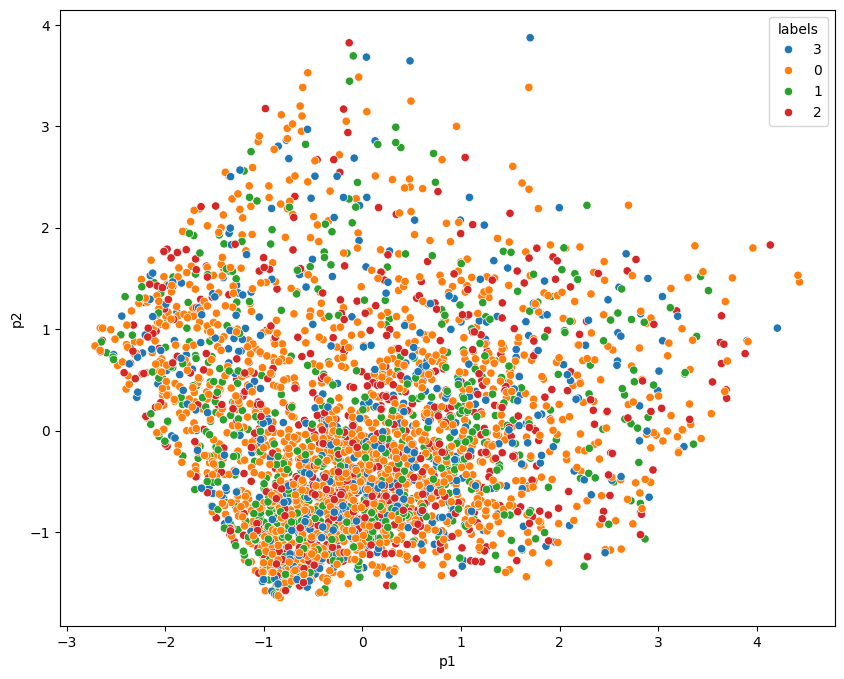

In [48]:
# PCA não se adequa a essa base de dados
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pc=pca.fit_transform(rfm_df_scaled)

pdf=pd.DataFrame(data=pc,columns=['p1','p2'])
pdf['labels']=df_kmeans['Cluster_Id']
sns.scatterplot(data=pdf,x='p1',y='p2',hue='labels')
pdf.head()

In [49]:
rfm.groupby('Cluster_Id').count()

id_cliente  ticket_medio  frequencia  recencia
Cluster_Id                                                
0                 1771          1771        1771      1771
1                  749           749         749       749
2                  673           673         673       673
3                  554           554         554       554

# Avaliando Kmeans

In [50]:
#Plota comparação entre as variáveis para análise do Cluster

f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='frequencia',hue='Cluster_Id',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='recencia',hue='Cluster_Id',ax=axes[2],palette="deep")


<Axes: xlabel='ticket_medio', ylabel='recencia'>

In [51]:
# Box plot para visualizar Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='ticket_medio', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='ticket_medio'>

<Axes: xlabel='Cluster_Id', ylabel='frequencia'>

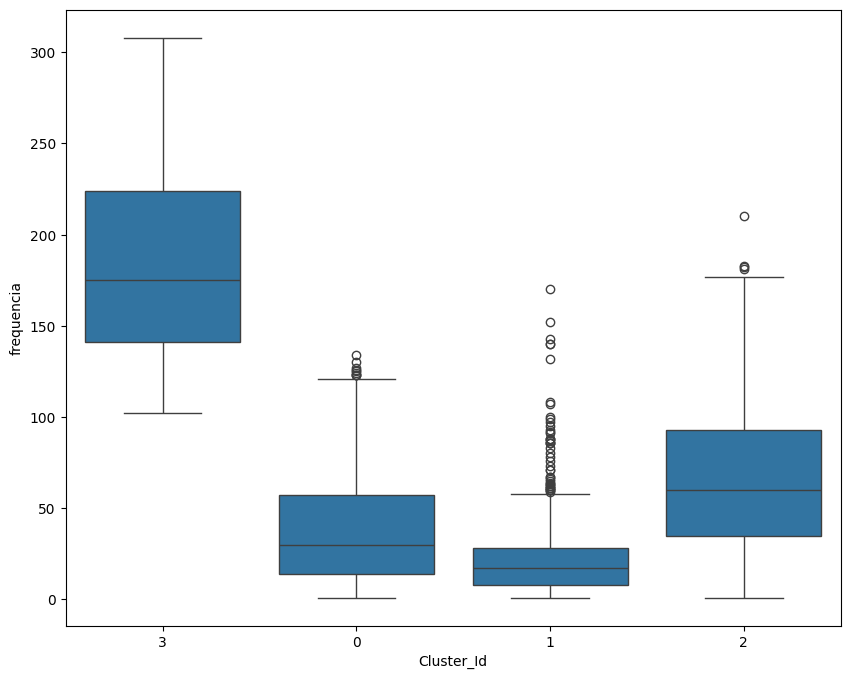

In [52]:
# Box plot para visualizar Cluster Id vs Frequencia

sns.boxplot(x='Cluster_Id', y='frequencia', data=rfm)

In [53]:
# Box plot para visualizar Cluster Id vs Recência

sns.boxplot(x='Cluster_Id', y='recencia', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='recencia'>

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering,
- Divisive
- Agglomerative.

In [54]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograma")
dend = shc.dendrogram(shc.linkage(rfm_df_scaled, method='ward'))
plt.axhline(y=40, color='r', linestyle='--')

#### Cutting the Dendrogram based on K

In [55]:
cluster = AgglomerativeClustering(n_clusters=4)
cluster_labels = cluster.fit_predict(rfm_df_scaled)
rfm['Cluster_Labels'] = cluster_labels
hierarq = rfm
rfm.head()

id_cliente  ticket_medio  frequencia  recencia Cluster_Id  Cluster_Labels
1    12347.0     68.744286         182      4674          3               2
2    12348.0     44.677500          31      4747          0               1
4    12350.0     65.300000          17      4982          1               0
6    12353.0     24.300000           4      4876          1               3
8    12355.0     54.650000          13      4886          1               3

In [56]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='frequencia', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='frequencia'>

<Axes: xlabel='Cluster_Labels', ylabel='recencia'>

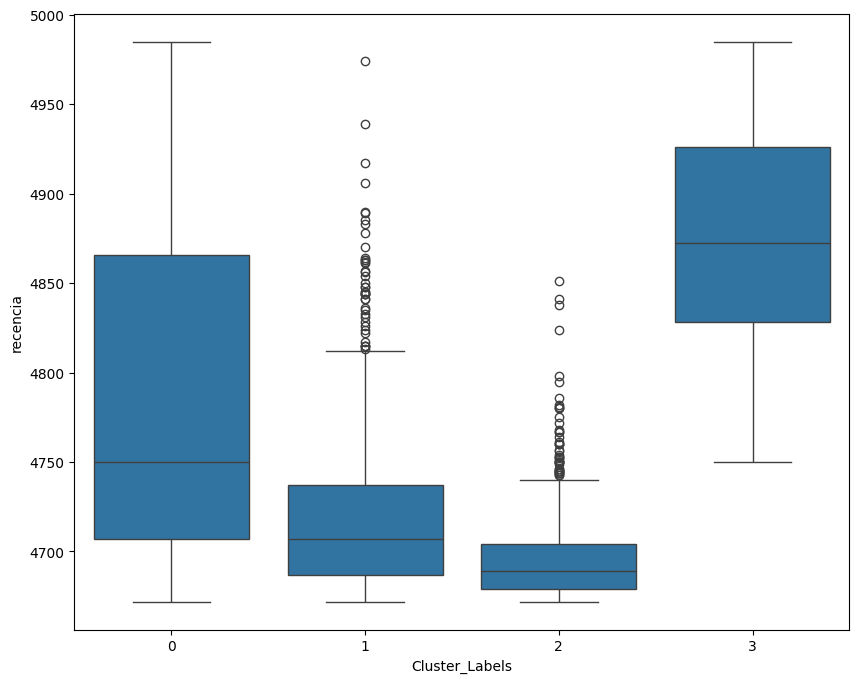

In [57]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='recencia', data=rfm)

<Axes: xlabel='P1', ylabel='P2'>

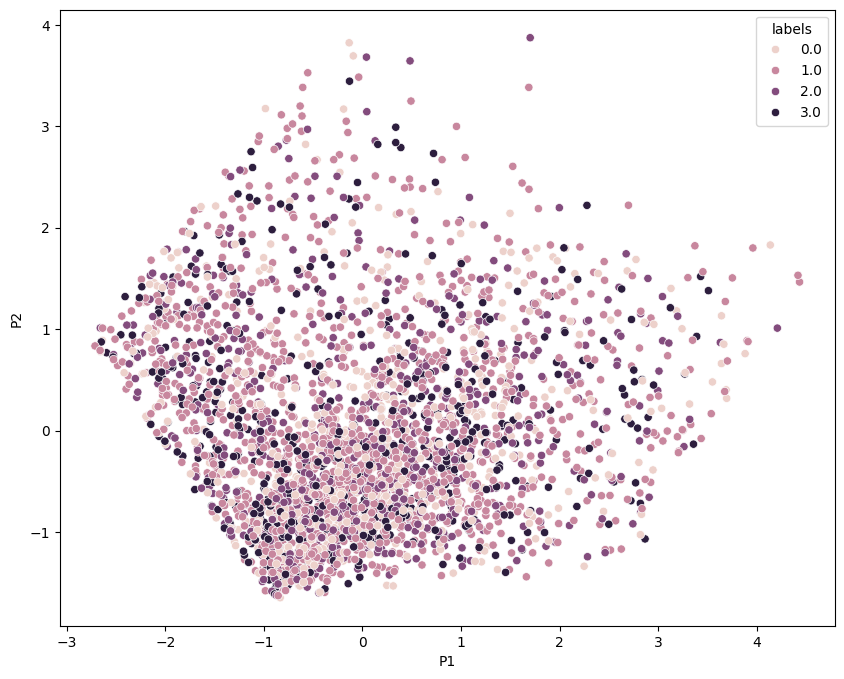

In [58]:
#para visualizar melhor essa distribuição, podemos cruzar algumas variáveis e ver como fica a clusterização
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rfm_df_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['P1', 'P2'])
principalDf['labels']=rfm['Cluster_Labels']
sns.scatterplot(data=principalDf,x='P1',y='P2',hue='labels')

In [59]:
#Plota comparação entre as variáveis para análise do Cluster

f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='Cluster_Labels',ax=axes[0],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='frequencia',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='recencia',hue='Cluster_Labels',ax=axes[2],palette="deep")

<Axes: xlabel='ticket_medio', ylabel='recencia'>

### DBScan

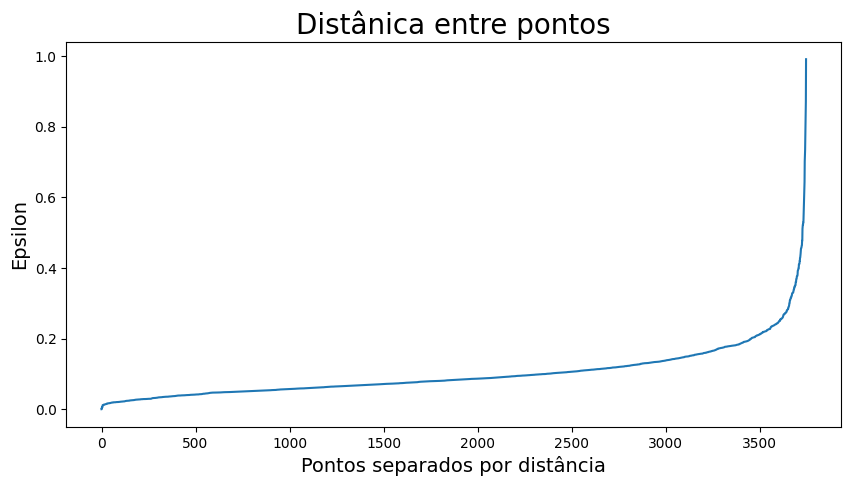

In [60]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(rfm_df_scaled)
distances, indices = nbrs.kneighbors(rfm_df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Distânica entre pontos',fontsize=20)
plt.xlabel('Pontos separados por distância',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [61]:
db = DBSCAN(eps=0.4, min_samples=10).fit(rfm_df_scaled)
labels_dbscan = db.labels_
df_dbscan=rfm
df_dbscan['labels_dbscan']=labels_dbscan.astype('str')

In [62]:
#Ele não consegue criar clusters
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rfm_df_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['P1', 'P2'])
principalDf['labels']=df_dbscan['labels_dbscan']
sns.scatterplot(data=principalDf,x='P1',y='P2',hue='labels')

<Axes: xlabel='P1', ylabel='P2'>

## Comparativa entre resultados

<Axes: xlabel='frequencia', ylabel='recencia'>

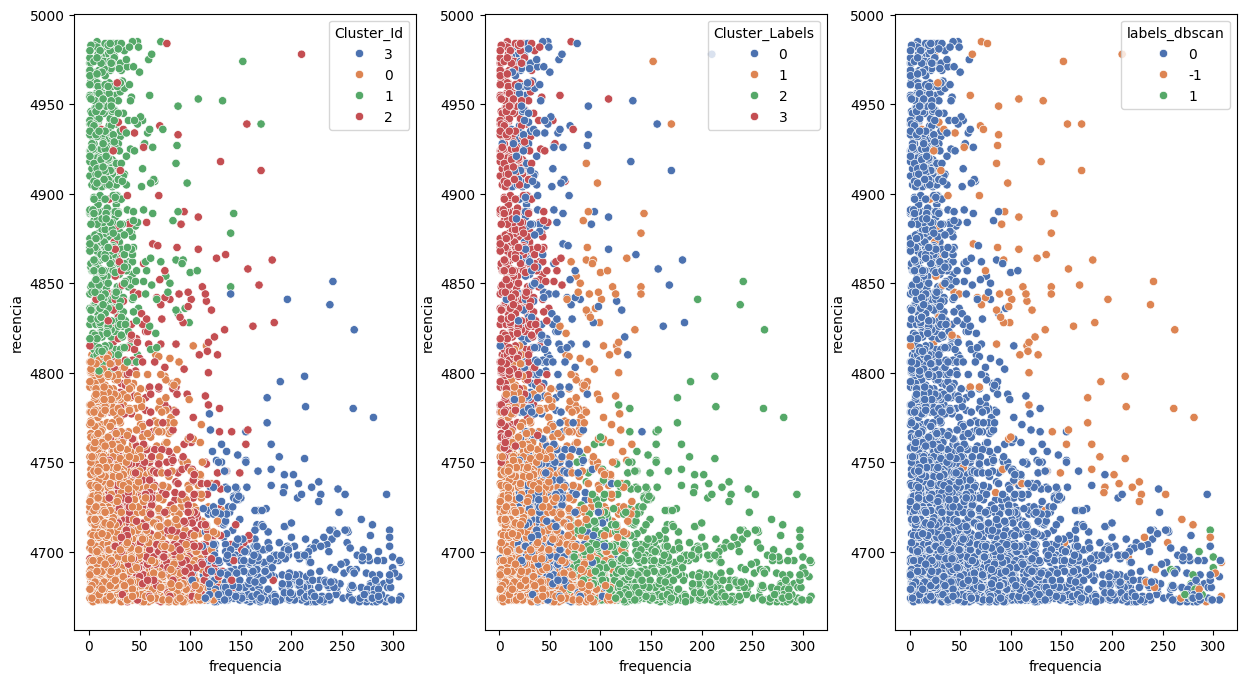

In [63]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=df_kmeans,x='frequencia',y='recencia',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=hierarq,x='frequencia',y='recencia',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='labels_dbscan',ax=axes[2],palette="deep")

<Axes: xlabel='frequencia', ylabel='ticket_medio'>

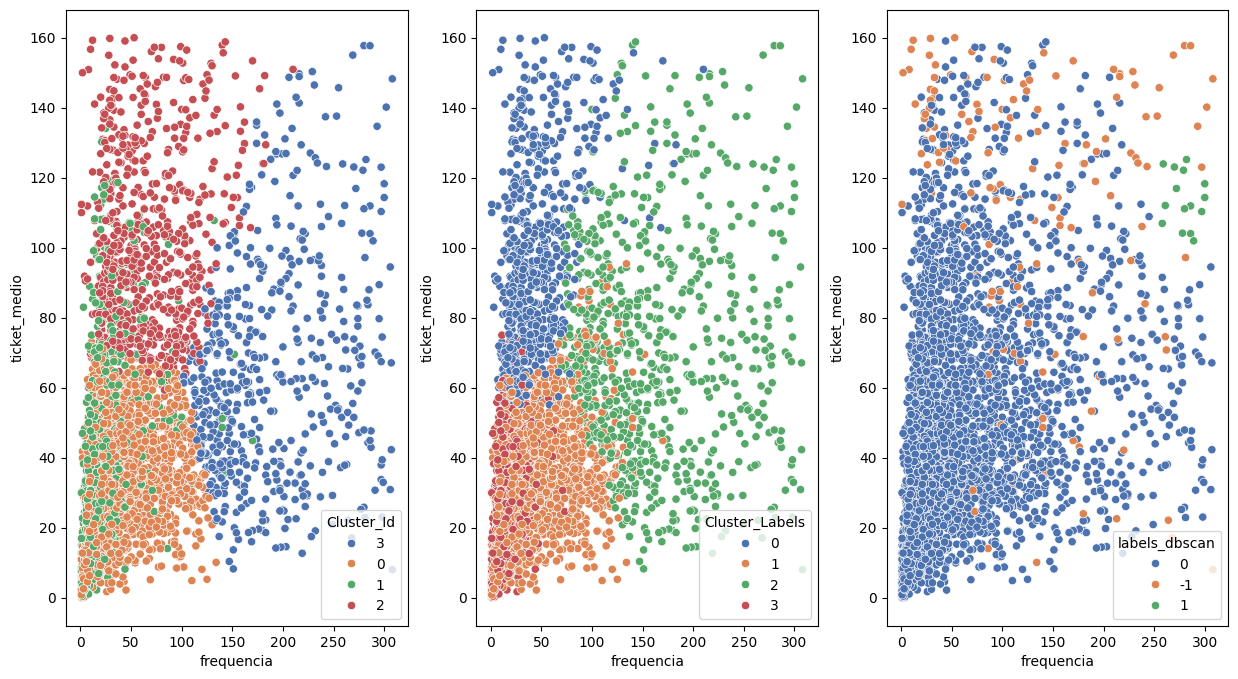

In [64]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=df_kmeans,x='frequencia',y='ticket_medio',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=hierarq,x='frequencia',y='ticket_medio',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='frequencia',y='ticket_medio',hue='labels_dbscan',ax=axes[2],palette="deep")

<Axes: xlabel='labels_dbscan', ylabel='recencia'>

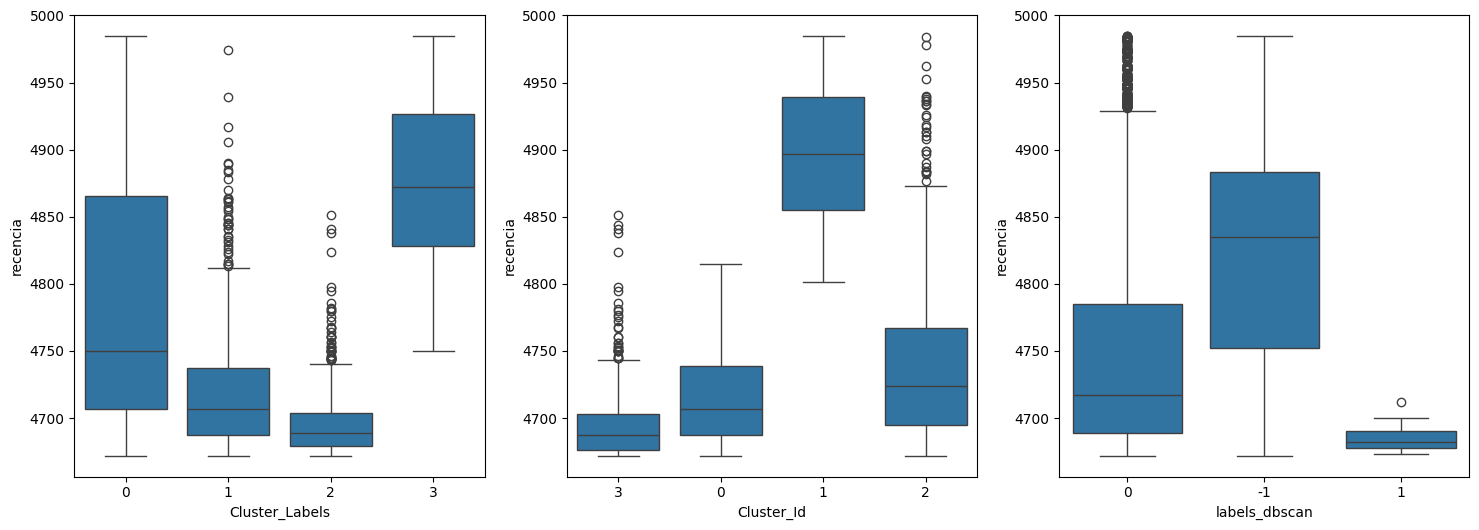

In [65]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(18, 6))
sns.boxplot(x='Cluster_Labels', y='recencia', data=rfm,ax=axes[0])
sns.boxplot(x='Cluster_Id', y='recencia', data=rfm,ax=axes[1])
sns.boxplot(x='labels_dbscan', y='recencia', data=rfm,ax=axes[2])

<Axes: xlabel='labels_dbscan', ylabel='frequencia'>

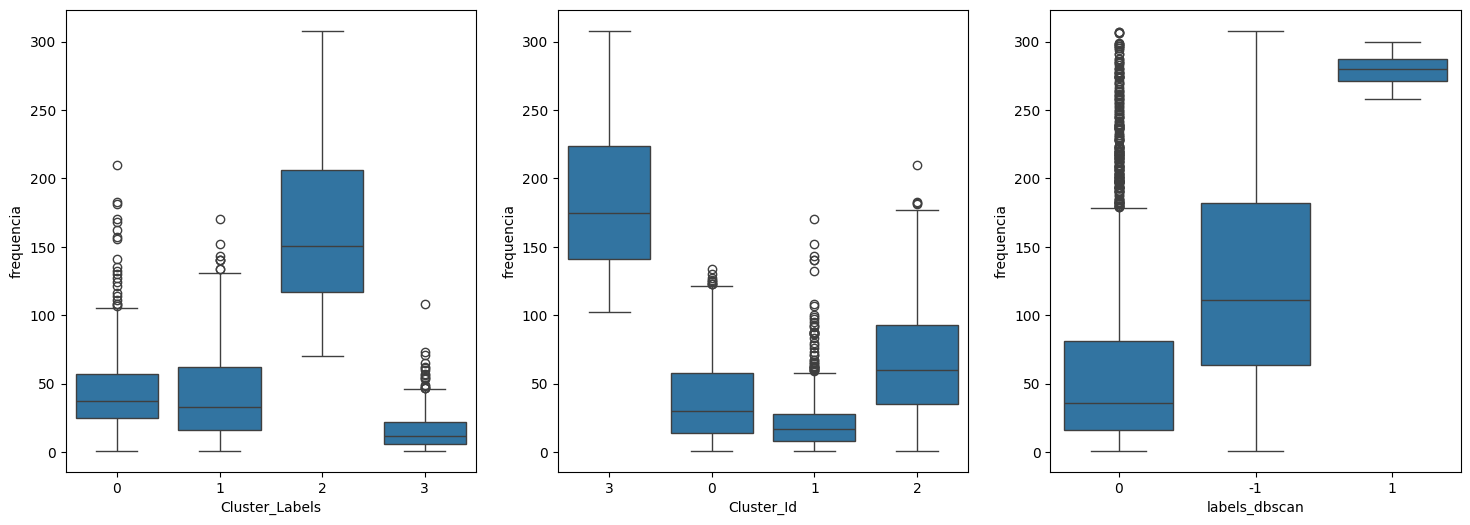

In [66]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(18, 6))
sns.boxplot(x='Cluster_Labels', y='frequencia', data=rfm,ax=axes[0])
sns.boxplot(x='Cluster_Id', y='frequencia', data=rfm,ax=axes[1])
sns.boxplot(x='labels_dbscan', y='frequencia', data=rfm,ax=axes[2])

<a id="5"></a> <br>
## Step 5 : Final Analysis

Kmeans com 2 clusters
- Cliente no Cluster 1 tem alta frequência e uma baixa recência e um alto ticket, significando que ele compra bastante e atualmente consome. Sugestão: Promoções e pontos para ele seguir cliente.
- Clientes do cluster 0 já possuem um ticket menor e uma boa parte possui recencia alta e pouca frequencia. Uma sugestão seria fidelizar esse cliente através de promoções.

Algoritmo bom para escalar, caso o cliente deseje manter esse modelo.

Cluster Hierárquico com 2 clusters
- Cliente no Cluster 1 tem alta frequência e uma baixa recência e um alto ticket, significando que ele compra bastante e atualmente consome. Sugestão: Promoções e pontos para ele seguir cliente.
- Clientes do cluster 0 já possuem um ticket menor e uma boa parte possui recencia alta e pouca frequencia. Uma sugestão seria fidelizar esse cliente através de promoções.

Algoritmo fácil e intuitivo, porém temos problema em escalar para grandes volumes de dados.

DBSCAN
Algoritmo não se adaptou a modelagem a ao tipo de base, com isso não foi útil para análises.

## Contato

**Nome:** Lucas Oliveira Alves  
**Email:** [alves_lucasoliveira@usp.br](mailto:alves_lucasoliveira@usp.br)  
**LinkedIn:** [linkedin.com/in/cyblx](https://www.linkedin.com/in/cyblx/)  
**GitHub:** [github.com/cyblx](https://github.com/cyblx)